

# Logistic Regression with Python

For this lecture we will be working with the [Titanic Data Set from Kaggle](https://www.kaggle.com/c/titanic). This is a very famous data set and very often is a student's first step in machine learning! 

We'll be trying to predict a classification- survival or deceased.
Let's begin our understanding of implementing Logistic Regression in Python for classification.

We'll use a "semi-cleaned" version of the titanic data set, if you use the data set hosted directly on Kaggle, you may need to do some additional cleaning not shown in this lecture notebook.

## Import Libraries
Let's import some libraries to get started!

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

## The Data

Let's start by reading in the titanic_train.csv file into a pandas dataframe.

In [ ]:
train = pd.read_csv('titanic.csv', delimiter = '\t')

In [ ]:
train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


# Exploratory Data Analysis

Let's begin some exploratory data analysis! We'll start by checking out missing data!

## Missing Data

We can use seaborn to create a simple heatmap to see where we are missing data!

In [ ]:
train.shape

In [ ]:
train.isnull().sum()  # cabin more than 40% data is missing so , we drop this column

In [ ]:
sns.heatmap(train.isnull(),yticklabels=False,cbar=False,cmap='viridis')

Roughly 20 percent of the Age data is missing. The proportion of Age missing is likely small enough for reasonable replacement with some form of imputation. Looking at the Cabin column, it looks like we are just missing too much of that data to do something useful with at a basic level. We'll probably drop this later, or change it to another feature like "Cabin Known: 1 or 0"

Let's continue on by visualizing some more of the data! Check out the video for full explanations over these plots, this code is just to serve as reference.

In [ ]:
sns.set_style('whitegrid')
sns.countplot(x='Survived',data=train,palette='RdBu_r')

In [ ]:
sns.set_style('whitegrid')
sns.countplot(x='Survived',hue='Sex',data=train,palette='RdBu_r')

In [ ]:
sns.set_style('whitegrid')
sns.countplot(x='Survived',hue='Pclass',data=train,palette='rainbow')

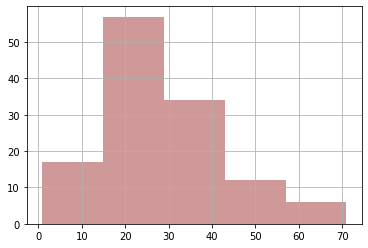

In [ ]:
train['Age'].hist(bins=5,color='darkred',alpha=0.4)

In [ ]:
sns.countplot(x='SibSp',data=train)

In [ ]:
train['Fare'].hist(color='green',bins=40,figsize=(8,4))

___
## Data Cleaning
We want to fill in missing age data instead of just dropping the missing age data rows. One way to do this is by filling in the mean age of all the passengers (imputation).
However we can be smarter about this and check the average age by passenger class. For example:


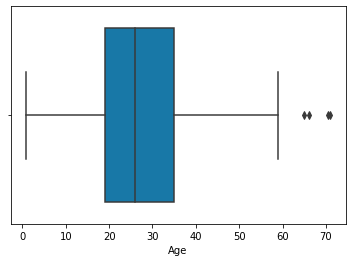

In [ ]:
sns.boxplot(x='Age',data=train,palette='winter')

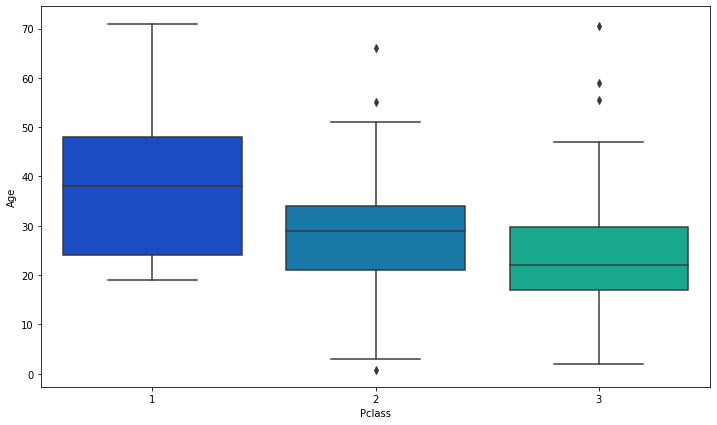

In [ ]:
plt.figure(figsize=(12, 7))
sns.boxplot(x='Pclass',y='Age',data=train,palette='winter')

In [ ]:
# Outlier Treatment
c1 = (train['Pclass']==3)&(train['Age']>42)
c2 = (train['Pclass']==2)&(train['Age']>50)
c3 = (train['Pclass']==2)&(train['Age']<8)

train['new age']=np.select([c1,c2,c3],[23,27,27], train['Age'])

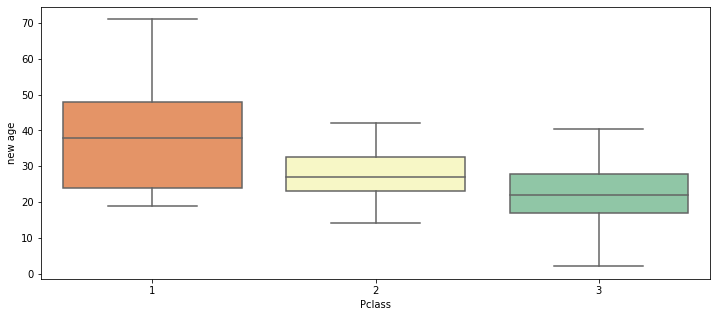

In [ ]:
plt.figure(figsize=(12, 5))
sns.boxplot(x='Pclass',y='new age',data=train,palette='Spectral')

In [ ]:
# Treat NAN values for AGE
train.Age.isna().sum() # 30 nan
train.Age.fillna(train.Age.median(), inplace = True)
train.Age.isna().sum() # 0 nan

In [ ]:
# Treat NAN values for EMBARKD
train.Embarked.isna().sum() # 1 nan 
train.Embarked.mode()[0] # finding the most common occuring value from the column
train.Embarked.fillna(train.Embarked.mode()[0], inplace = True)
train.Embarked.isna().sum() # 0 nan

0

We can see the wealthier passengers in the higher classes tend to be older, which makes sense. We'll use these average age values to impute based on Pclass for Age.

In [ ]:
# treating Age NAN Values basied on PClass
def impute_age(cols):
    Age2 = cols[0]
    Pclass2 = cols[1]
    
    if pd.isnull(Age2):

        if Pclass2 == 1:
            return train[train['Pclass']==1]['Age'].median()

        elif Pclass2 == 2:
            return train[train['Pclass']==2]['Age'].median()

        else:
            return train[train['Pclass']==3]['Age'].median()

    else:
        return Age2

In [ ]:
train['Age'] = train[['Age','Pclass']].apply(impute_age,axis=1)

In [ ]:
sns.heatmap(train.isnull(),yticklabels=False,cbar=False,cmap='viridis')

Great! Let's go ahead and drop the Cabin column and the row in Embarked that is NaN.

In [ ]:
train.drop('Cabin',axis=1,inplace=True)

In [ ]:
train.head()

In [ ]:
# train.dropna(inplace=True)

## Converting Categorical Features 

We'll need to convert categorical features to dummy variables using pandas! Otherwise our machine learning algorithm won't be able to directly take in those features as inputs.

In [ ]:
train.info()

In [ ]:
train = pd.get_dummies(train, columns = ['Sex', 'Embarked'],drop_first=True)

In [ ]:
train.head(2)

,PassengerId,Survived,Pclass,Name,Age,SibSp,Parch,Ticket,Fare,Sex_male,Embarked_Q,Embarked_S
0,1,0,3,"Braund, Mr. Owen Harris",22.0,1,0,A/5 21171,7.2500,1,0,1
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",38.0,1,0,PC 17599,71.2833,0,0,0


# Building a Logistic Regression model

Let's start by splitting our data into a training set and test set (there is another test.csv file that you can play around with in case you want to use all this data for training).

## Train Test Split

In [ ]:
from sklearn.model_selection import train_test_split

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(train.drop(['Survived','Age','Name','Ticket','PassengerId'],axis=1), 
                                                    train['Survived'], test_size=0.30, 
                                                    random_state=101)

## Training and Predicting

In [ ]:
from sklearn.linear_model import LogisticRegression

In [ ]:
logmodel2 = LogisticRegression()
logmodel2.fit(X_train,y_train)

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [ ]:
X_test.head()

,Pclass,SibSp,Parch,Fare,Sex_male,Embarked_Q,Embarked_S,new age
80,3,0,0,9.000,1,0,1,22.0
106,3,0,0,7.650,0,0,1,21.0
116,3,0,0,7.750,1,1,0,23.0
129,3,0,0,6.975,1,0,1,23.0
32,3,0,0,7.750,0,1,0,22.0


In [ ]:
predictions = logmodel.predict(X_test)
predictions

array([0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0,
       0, 1, 1, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0,
       0, 0, 1])

In [ ]:
y_test.head()

In [ ]:
predictions[:5]

array([0, 1, 0, 0, 1])

In [ ]:
logmodel.predict(np.array([[1,0,2,30,0,0,0,70], [1,0,2,30,1,0,0,70]]))

array([1, 0])

In [ ]:
logmodel.predict(X_test.iloc[0:2].values)

array([0, 1])

## Evaluation

We can check precision,recall,f1-score using classification report!

In [ ]:
from sklearn.metrics import classification_report, precision_score, recall_score, accuracy_score, f1_score, confusion_matrix,classification_report

In [ ]:
precision_score(y_test,predictions)  # 3

0.8

In [ ]:
recall_score(y_test,predictions)  # 2

0.5217391304347826

In [ ]:
accuracy_score(y_test,predictions)  # 4

0.7021276595744681

In [ ]:
f1_score(y_test,predictions)   # 1

0.6315789473684211

In [ ]:
confusion_matrix(y_test,predictions)


# specificity =  TN/(FP+TN)

array([[21,  3],
       [11, 12]])

In [ ]:
%%time
import pickle
# # saved the trained model in file with given name
pickle_out = open("titanic_pred.pickle","wb") # name of my pickle file , wb -write
pickle.dump(logmodel, pickle_out)
pickle_out.close()

CPU times: user 584 µs, sys: 0 ns, total: 584 µs
Wall time: 596 µs


In [ ]:
# loading the pickeled model
pickle_in = open("titanic_pred.pickle","rb") # rb -> read the pickel file
trained_model = pickle.load(pickle_in)
trained_model.predict(X_test)

array([0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0,
       0, 1, 1, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0,
       0, 0, 1])

In [ ]:
trained_model.predict(np.array([[3,0,0,7,21,1,0,1]]))

array([0])

In [ ]:
X_test.head(1)

In [ ]:
trained_model.predict(np.array([[1,55,0,1,150,55,1,0,0]]))